<a href="https://colab.research.google.com/github/AshleyBrooks213/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Ashley_Brooks_Unit2_MOD3_Sprint1_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

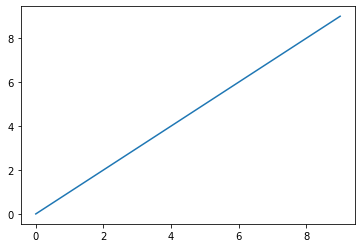

In [1]:
import matplotlib.pyplot as plt
plt.plot(range(10))
plt.show()

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv',
                 parse_dates = ['SALE DATE'])

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]



#Change Datetime object to Int << maybe I don't need to do this for this problem
#import datetime as dt
#df['SALE_DATE'] = df['SALE_DATE'].map(dt.datetime.toordinal)

#Change df['SALE_DATE'] to index
index_col = 'SALE DATE'

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [5]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'




In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01


In [7]:
df['SALE_PRICE'].max()
df['SALE_PRICE'].min()

0

In [8]:
df['BUILDING_CLASS_CATEGORY'].unique()

array(['13 CONDOS - ELEVATOR APARTMENTS', '21 OFFICE BUILDINGS',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL',
       '07 RENTALS - WALKUP APARTMENTS', '01 ONE FAMILY DWELLINGS',
       '02 TWO FAMILY DWELLINGS', '05 TAX CLASS 1 VACANT LAND',
       '29 COMMERCIAL GARAGES', '32 HOSPITAL AND HEALTH FACILITIES',
       '33 EDUCATIONAL FACILITIES', '08 RENTALS - ELEVATOR APARTMENTS',
       '31 COMMERCIAL VACANT LAND', '41 TAX CLASS 4 - OTHER',
       '14 RENTALS - 4-10 UNIT', '03 THREE FAMILY DWELLINGS',
       '22 STORE BUILDINGS', '10 COOPS - ELEVATOR APARTMENTS',
       '44 CONDO PARKING', '47 CONDO NON-BUSINESS STORAGE',
       '12 CONDOS - WALKUP APARTMENTS', '43 CONDO OFFICE BUILDINGS',
       '09 COOPS - WALKUP APARTMENTS', '27 FACTORIES',
       '04 TAX CLASS 1 CONDOS', '17 CONDO COOPS', '26 OTHER HOTELS',
       '45 CONDO HOTELS', '06 TAX CLASS 1 - OTHER', '30 WAREHOUSES',
       '46 CONDO STORE BUILDINGS', '25 LUXURY HOTELS', '34 THEATRES',
       '37 RELIGIOUS FACILITIES', '49 C

In [9]:
#df['APARTMENT_NUMBER'] = df['APARTMENT_NUMBER'].fillna(0)
#df['EASE-MENT'] = df['EASE-MENT'].fillna(0)


df.drop(columns='EASE-MENT', axis=1, inplace=True)
df.drop(columns='APARTMENT_NUMBER', axis=1, inplace=True)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01


In [10]:
def wrangle(df: "Old DataFrame") -> "Cleaned DataFrame":
  """This Function will
  clean up my
  dataframe"""

  #Make a copy of df
  df = df.copy()
  #Drop columns in BUILDING_CLASS_CATEGOR that are not == '01 ONE FAMILY DWELLINGS'
  ##and the sale price more than 100 thousand and less than 2 million.
  df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
          (df['SALE_PRICE'] > 100000) &
          (df['SALE_PRICE'] < 2000000)]

  return df

df1 = wrangle(df)



In [11]:
df1 = df1.set_index('SALE_DATE')

df1.dropna(inplace=True)

df1.head()
df1.shape

(3151, 18)

##**Split Data**

Split target vector from feature matrix

In [12]:
target = 'SALE_PRICE'
y = df1[target]
X = df1.drop(columns=target)

Split data into training and test sets

In [13]:
cutoff = '2019-03-31'
mask = X.index < cutoff

cutoff2 = '2019-04-30'
mask2 = X.index == cutoff2

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask2], y.loc[~mask2]

##**Establish Baseline**

Regression problem because we are predicting the continuous value of price

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 214721.52773001452


##**Build Linear Regression Model**

OneHotEncoder

In [15]:
#Step 1: Import my transformer class
from category_encoders import OneHotEncoder

#Step 2: Instantiate my transformer (so it's an object)
ohe = OneHotEncoder(use_cat_names=True)

#Step 3: Fit my transformer on the TRAINING data (the feature matrix only)
ohe.fit(X_train)

#Step 4: Transform data (DO NOT RETRAIN ON TEST DATA)
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [38]:
from sklearn.feature_selection import SelectKBest
skb = SelectKBest(k=5)

skb.fit(XT_train, y_train)

XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   4   12   28   29   36   37   42   51   60   72   77   81   83   84
   85   91   92  104  111  112  114  121  125  130  131  144  150  153
  164  175  176  177  179  184  186  189  197  206  208  215  224  230
  232  247  250  253  255  261  262  263  266  278  282  299  310  313
  314  326  329  337  347  350  354  360  363  365  369  377  378  381
  382  385  386  387  389  390  399  408  411  412  415  416  429  431
  433  437  441  442  448  452  457  461  477  478  483  490  491  497
  506  510  514  518  519  522  526  530  531  534  535  536  545  550
  559  562  564  567  572  588  592  595  597  599  603  604  607  614
  616  622  624  625  631  636  638  639  640  642  643  644  646  649
  651  653  658  660  667  668  674  682  687  688  692  694  696  697
  700  707  710  712  714  722  725  729  730  739  751  753  754  767
  777  781  782  783  785  788 

In [39]:
#Step 1: Import my prediction class
from sklearn.linear_model import LinearRegression, Ridge

#Step 2: Instantiate my predictor (so it's an object)
model_lr = LinearRegression()

#Step 3: Fit model to TRAINING data 
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##**Check Metrics**

In [40]:
## I TRIED USING XTT_train and XTT_test but it was throwing errors and I have NO IDEA what they mean 
## HELP????

print('training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train)))
print('test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

training MAE: 562.1531321674312
test MAE: 40009631109.11478


##**Build Ridge Regression Model**

In [41]:
model_r = Ridge(alpha=1)
model_r.fit(XT_train, y_train);

In [42]:
print('training MAE:', mean_absolute_error(y_train, model_r.predict(
    XT_train)))
print('test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))
print('Training R^2:', model_r.score(XT_train, y_train))
print('Test R^2:', model_r.score(XT_test, y_test))

training MAE: 65197.62154278302
test MAE: 83491.24349146939
Training R^2: 0.9025834644085862
Test R^2: 0.8008244082011314


##**How do I know what the right value for a hyperparameter is?**

In [43]:
#3151
k_values = range(2, 10, 2)

training_mae=[]
test_mae=[]

for k in k_values:
  #Fit transformer, transform data
  skb=SelectKBest(k=k)
  skb.fit(XT_train, y_train)
  XTT_train=skb.transform(XT_train)
  XTT_test=skb.transform(XT_test)

  #Fit model
  model_lr=LinearRegression()
  model_lr.fit(XTT_train, y_train)

  #Get Metrics
  training_mae.append(mean_absolute_error(y_train, model_lr.
                                          predict(XTT_train)))
  test_mae.append(mean_absolute_error(y_test, model_lr.
                                      predict(XTT_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   4   12   28   29   36   37   42   51   60   72   77   81   83   84
   85   91   92  104  111  112  114  121  125  130  131  144  150  153
  164  175  176  177  179  184  186  189  197  206  208  215  224  230
  232  247  250  253  255  261  262  263  266  278  282  299  310  313
  314  326  329  337  347  350  354  360  363  365  369  377  378  381
  382  385  386  387  389  390  399  408  411  412  415  416  429  431
  433  437  441  442  448  452  457  461  477  478  483  490  491  497
  506  510  514  518  519  522  526  530  531  534  535  536  545  550
  559  562  564  567  572  588  592  595  597  599  603  604  607  614
  616  622  624  625  631  636  638  639  640  642  643  644  646  649
  651  653  658  660  667  668  674  682  687  688  692  694  696  697
  700  707  710  712  714  722  725  729  730  739  751  753  754  767
  777  781  782  783  785  788 

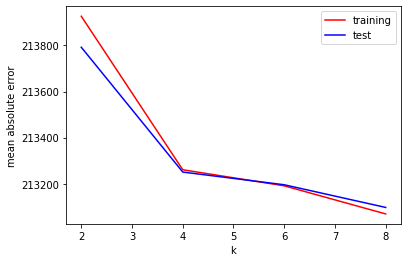

In [44]:
plt.plot(k_values, training_mae, color='red', label='training')
plt.plot(k_values, test_mae, color='blue', label='test')

plt.xlabel('k')
plt.ylabel('mean absolute error')
plt.legend()

plt.show();

##**Communicate Results**

I don't really understand all of this very well, yet. 
In fact I am pretty sure I did some things wrong. 

I would love if someone could go through this with me and explain it and see what I could do better or fix.

In [45]:
##I'm NOT SURE HOW TO FIX THIS ERROR!!! 

coefs=pd.Series(model_lr.coef_, index=ohe.get_feature_names())
coefs.sort_values().head().plot(kind='barh')

ValueError: ignored

In [46]:
XT_train.describe()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ADDRESS_4832 BAY PARKWAY,ADDRESS_80-23 232ND STREET,ADDRESS_1260 RHINELANDER AVE,ADDRESS_469 E 25TH ST,ADDRESS_5521 WHITTY LANE,ADDRESS_1747 EAST 23RD STREET,ADDRESS_1582 EAST 15TH STREET,ADDRESS_201-08 50TH AVENUE,ADDRESS_85-11 57 ROAD,ADDRESS_53-19 198TH STREET,...,"LAND_SQUARE_FEET_5,425","LAND_SQUARE_FEET_1,767","LAND_SQUARE_FEET_1,293","LAND_SQUARE_FEET_2,708","LAND_SQUARE_FEET_2,233","LAND_SQUARE_FEET_2,260","LAND_SQUARE_FEET_5,005","LAND_SQUARE_FEET_1,235","LAND_SQUARE_FEET_4,298","LAND_SQUARE_FEET_1,060",LAND_SQUARE_FEET_946,"LAND_SQUARE_FEET_1,698","LAND_SQUARE_FEET_3,990","LAND_SQUARE_FEET_3,012","LAND_SQUARE_FEET_2,231","LAND_SQUARE_FEET_4,485","LAND_SQUARE_FEET_1,918","LAND_SQUARE_FEET_2,020","LAND_SQUARE_FEET_1,380","LAND_SQUARE_FEET_3,338","LAND_SQUARE_FEET_3,692","LAND_SQUARE_FEET_2,755","LAND_SQUARE_FEET_3,230","LAND_SQUARE_FEET_2,121","LAND_SQUARE_FEET_4,361","LAND_SQUARE_FEET_3,910",GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
count,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.0,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,...,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.0,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000
mean,0.158755,0.480255,0.096530,0.264061,0.000399,0.941364,0.030714,0.008775,0.003191,0.006781,0.004787,0.004388,1.0,0.987635,0.012365,6758.303949,75.778221,0.076984,0.366574,0.310730,0.026725,0.163941,0.015158,0.015556,0.005185,0.005584,0.012365,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,...,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,0.000399,1473.744715,1944.766653,1.0,0.076984,0.366574,0.310730,0.026725,0.164739,0.015158,0.015556,0.005185,0.005584,0.012365,0.000399
std,0.365521,0.499710,0.295375,0.440920,0.019972,0.234989,0.172576,0.093284,0.056411,0.082084,0.069033,0.066108,0.0,0.110532,0.110532,3975.909029,157.531138,0.266620,0.481965,0.462885,0.161311,0.370296,0.122204,0.123776,0.071838,0.074535,0.110532,0.019972,